In [1]:
import torch, torchvision
print(torch.__version__)
print(torch.cuda.is_available())

1.12.1+cu113
True


In [ ]:
! nvidia-smi

Sun Sep 11 07:22:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install mmcv -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
     |████████████████████████████████| 563 kB 14.9 MB/s 
     |████████████████████████████████| 190 kB 90.1 MB/s 
  Created wheel for mmcv: filename=mmcv-1.6.1-py2.py3-none-any.whl size=860296 sha256=d4929a2501d0bc1111f475e6bfaf8bf09a84f45370835f6784a5874f30c8e29e
  Stored in directory: /root/.cache/pip/wheels/e0/43/68/40160e8aa085d474903f0ad3764bac92e698936bfcf8a5454b
Successfully built mmcv


In [ ]:
# !git clone https://github.com/open-mmlab/mmclassification.git
%cd /content/drive/MyDrive/mmclassification/

/content/drive/MyDrive/mmclassification


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/mmclassification
  Running setup.py develop for mmcls


In [ ]:
import mmcls
print(mmcls.__version__)

0.23.2


In [ ]:
config_file = '/content/drive/MyDrive/mmclassification/configs/resnet/resnet50_32xb64-warmup_in1k.py'
checkpoint_file = 'https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth'

In [ ]:
import mmcv
from mmcls.apis import inference_model, init_model, show_result_pyplot

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


In [ ]:
device = 'cuda'

In [ ]:
# Build the model according to the config file and load the checkpoint.
model = init_model(config_file, checkpoint_file, device=device)

load checkpoint from http path: https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth


In [ ]:
# The model's inheritance relationship
model.__class__.__mro__

(mmcls.models.classifiers.image.ImageClassifier,
 mmcls.models.classifiers.base.BaseClassifier,
 mmcv.runner.base_module.BaseModule,
 torch.nn.modules.module.Module,
 object)

In [ ]:
# config_file = 'configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py'
# Load the base config file
from mmcv import Config
cfg = Config.fromfile(config_file)
# Modify the number of classes in the head.
cfg.model.head.num_classes = 5
cfg.model.head.topk = (1, )


# Load the pre-trained model's checkpoint.
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

# Specify sample size and number of workers.
cfg.data.samples_per_gpu = 32
cfg.data.workers_per_gpu = 1

# Specify the path and meta files of training dataset
cfg.data.train.data_prefix = '/content/drive/MyDrive/export/mmclass/train/'
cfg.data.train.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
# cfg.data.train.ann_file = '/content/drive/MyDrive/export/train_0829.txt'

# Specify the path and meta files of validation dataset
cfg.data.val.data_prefix = '/content/drive/MyDrive/export/mmclass/val/'
cfg.data.val.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
cfg.data.val.ann_file = "/content/drive/MyDrive/export/mmclass/meta/val_0911_crop_class_google.txt"

# Specify the path and meta files of test dataset
cfg.data.test.data_prefix = '/content/drive/MyDrive/export/mmclass/test/'
cfg.data.test.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
cfg.data.test.ann_file = "/content/drive/MyDrive/export/mmclass/meta/test_0911_crop_class_google.txt"


# Specify the normalization parameters in data pipeline
normalize_cfg = dict(type='Normalize', mean=[124.508, 116.050, 106.438], std=[58.577, 57.310, 57.437], to_rgb=True)
cfg.data.train.pipeline[3] = normalize_cfg
cfg.data.val.pipeline[3] = normalize_cfg
cfg.data.test.pipeline[3] = normalize_cfg

# Modify the evaluation metric
cfg.evaluation['metric_options']={'topk': (1, )}

# Specify the optimizer
cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# Specify the learning rate scheduler
cfg.lr_config = dict(policy='step', step=1, gamma=0.1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=50)

# Specify the work directory
cfg.work_dir = './work_dirs/resnet_50'

# Output logs for every 10 iterations
cfg.log_config.interval = 10

# Set the random seed and enable the deterministic option of cuDNN
# to keep the results' reproducible.
from mmcls.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)

cfg.gpu_ids = range(1)
cfg.device = "cuda"

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='ImageClassifier',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(3, ),
        style='pytorch',
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth',
            prefix='backbone')),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=5,
        in_channels=2048,
        loss=dict(type='CrossEntropyLoss', loss_weight=1.0),
        topk=(1, )))
dataset_type = 'ImageNet'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='RandomResizedCrop', size=224),
    dict(type='RandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],


In [ ]:
import time
import mmcv
import os.path as osp

from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.apis import train_model

# Create the work directory
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# Build the classifier
model = build_classifier(cfg.model)
model.init_weights()
# Build the dataset
datasets = [build_dataset(cfg.data.train)]
# Add `CLASSES` attributes to help visualization
model.CLASSES = datasets[0].CLASSES
# # # Start fine-tuning
train_model(
    model,
    datasets,
    cfg,
    distributed=False,
    validate=True,
    timestamp=time.strftime('%Y%m%d_%H%M%S', time.localtime()),
    meta=dict())

2022-09-13 09:37:07,852 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth', 'prefix': 'backbone'}
2022-09-13 09:37:07,854 - mmcv - INFO - load backbone in model from: https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth
2022-09-13 09:37:07,984 - mmcv - INFO - initialize LinearClsHead with init_cfg {'type': 'Normal', 'layer': 'Linear', 'std': 0.01}
2022-09-13 09:37:07,987 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth 
 
2022-09-13 09:37:07,988 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth 
 
2022-09-13 09:37:07,990 - mmcv - I

load checkpoint from http path: https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth


2022-09-13 09:37:08,058 - mmcv - INFO - 
backbone.layer2.1.bn2.bias - torch.Size([128]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth 
 
2022-09-13 09:37:08,059 - mmcv - INFO - 
backbone.layer2.1.conv3.weight - torch.Size([512, 128, 1, 1]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth 
 
2022-09-13 09:37:08,061 - mmcv - INFO - 
backbone.layer2.1.bn3.weight - torch.Size([512]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth 
 
2022-09-13 09:37:08,062 - mmcv - INFO - 
backbone.layer2.1.bn3.bias - torch.Size([512]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth 
 
2022-09-13 09:37:08,063 - mmcv - INFO - 
backbone.layer2.2.conv1.weight - torch.Size([128, 512, 1, 1]): 
Pr

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 1.7 task/s, elapsed: 724s, ETA:     0s

2022-09-13 10:28:48,133 - mmcls - INFO - Epoch(val) [1][40]	accuracy_top-1: 0.0000
2022-09-13 10:28:55,817 - mmcls - INFO - Epoch [2][10/157]	lr: 5.000e-04, eta: 1 day, 5:09:00, time: 0.763, data_time: 0.700, memory: 2941, loss: 0.1165
2022-09-13 10:29:01,287 - mmcls - INFO - Epoch [2][20/157]	lr: 5.000e-04, eta: 1 day, 3:32:00, time: 0.547, data_time: 0.484, memory: 2941, loss: 0.0714
2022-09-13 10:29:06,574 - mmcls - INFO - Epoch [2][30/157]	lr: 5.000e-04, eta: 1 day, 2:05:13, time: 0.528, data_time: 0.467, memory: 2941, loss: 0.0500
2022-09-13 10:29:12,265 - mmcls - INFO - Epoch [2][40/157]	lr: 5.000e-04, eta: 1 day, 0:47:31, time: 0.569, data_time: 0.509, memory: 2941, loss: 0.1131
2022-09-13 10:29:17,572 - mmcls - INFO - Epoch [2][50/157]	lr: 5.000e-04, eta: 23:37:04, time: 0.531, data_time: 0.470, memory: 2941, loss: 0.0536
2022-09-13 10:29:23,267 - mmcls - INFO - Epoch [2][60/157]	lr: 5.000e-04, eta: 22:33:20, time: 0.570, data_time: 0.507, memory: 2941, loss: 0.0739
2022-09-13 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.8 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:30:37,512 - mmcls - INFO - Epoch(val) [2][40]	accuracy_top-1: 0.0000
2022-09-13 10:30:44,855 - mmcls - INFO - Epoch [3][10/157]	lr: 5.000e-05, eta: 15:15:17, time: 0.729, data_time: 0.665, memory: 2941, loss: 0.0264
2022-09-13 10:30:50,474 - mmcls - INFO - Epoch [3][20/157]	lr: 5.000e-05, eta: 14:48:48, time: 0.561, data_time: 0.499, memory: 2941, loss: 0.0753
2022-09-13 10:30:55,302 - mmcls - INFO - Epoch [3][30/157]	lr: 5.000e-05, eta: 14:23:35, time: 0.483, data_time: 0.422, memory: 2941, loss: 0.0404
2022-09-13 10:31:00,703 - mmcls - INFO - Epoch [3][40/157]	lr: 5.000e-05, eta: 13:59:58, time: 0.540, data_time: 0.479, memory: 2941, loss: 0.0658
2022-09-13 10:31:06,003 - mmcls - INFO - Epoch [3][50/157]	lr: 5.000e-05, eta: 13:37:37, time: 0.530, data_time: 0.467, memory: 2941, loss: 0.0367
2022-09-13 10:31:11,401 - mmcls - INFO - Epoch [3][60/157]	lr: 5.000e-05, eta: 13:16:30, time: 0.540, data_time: 0.479, memory: 2941, loss: 0.0265
2022-09-13 10:31:16,721 - mmcls - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 60.4 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:32:23,725 - mmcls - INFO - Epoch(val) [3][40]	accuracy_top-1: 0.0000
2022-09-13 10:32:31,080 - mmcls - INFO - Epoch [4][10/157]	lr: 5.000e-06, eta: 10:24:29, time: 0.730, data_time: 0.669, memory: 2941, loss: 0.0365
2022-09-13 10:32:36,196 - mmcls - INFO - Epoch [4][20/157]	lr: 5.000e-06, eta: 10:12:13, time: 0.512, data_time: 0.452, memory: 2941, loss: 0.0382
2022-09-13 10:32:41,729 - mmcls - INFO - Epoch [4][30/157]	lr: 5.000e-06, eta: 10:00:32, time: 0.553, data_time: 0.493, memory: 2941, loss: 0.0438
2022-09-13 10:32:47,214 - mmcls - INFO - Epoch [4][40/157]	lr: 5.000e-06, eta: 9:49:18, time: 0.548, data_time: 0.488, memory: 2941, loss: 0.0265
2022-09-13 10:32:52,603 - mmcls - INFO - Epoch [4][50/157]	lr: 5.000e-06, eta: 9:38:27, time: 0.539, data_time: 0.479, memory: 2941, loss: 0.0279
2022-09-13 10:32:57,583 - mmcls - INFO - Epoch [4][60/157]	lr: 5.000e-06, eta: 9:27:56, time: 0.498, data_time: 0.438, memory: 2941, loss: 0.0533
2022-09-13 10:33:02,737 - mmcls - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 60.4 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:34:09,687 - mmcls - INFO - Epoch(val) [4][40]	accuracy_top-1: 0.0000
2022-09-13 10:34:16,955 - mmcls - INFO - Epoch [5][10/157]	lr: 5.000e-07, eta: 7:56:03, time: 0.721, data_time: 0.657, memory: 2941, loss: 0.0599
2022-09-13 10:34:22,553 - mmcls - INFO - Epoch [5][20/157]	lr: 5.000e-07, eta: 7:49:06, time: 0.560, data_time: 0.500, memory: 2941, loss: 0.0235
2022-09-13 10:34:28,101 - mmcls - INFO - Epoch [5][30/157]	lr: 5.000e-07, eta: 7:42:20, time: 0.555, data_time: 0.493, memory: 2941, loss: 0.0329
2022-09-13 10:34:33,244 - mmcls - INFO - Epoch [5][40/157]	lr: 5.000e-07, eta: 7:35:42, time: 0.515, data_time: 0.453, memory: 2941, loss: 0.0282
2022-09-13 10:34:38,697 - mmcls - INFO - Epoch [5][50/157]	lr: 5.000e-07, eta: 7:29:19, time: 0.545, data_time: 0.484, memory: 2941, loss: 0.0382
2022-09-13 10:34:44,551 - mmcls - INFO - Epoch [5][60/157]	lr: 5.000e-07, eta: 7:23:11, time: 0.585, data_time: 0.523, memory: 2941, loss: 0.0462
2022-09-13 10:34:49,926 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.0 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:35:58,346 - mmcls - INFO - Epoch(val) [5][40]	accuracy_top-1: 0.0000
2022-09-13 10:36:06,258 - mmcls - INFO - Epoch [6][10/157]	lr: 5.000e-08, eta: 6:26:10, time: 0.786, data_time: 0.724, memory: 2941, loss: 0.0190
2022-09-13 10:36:11,664 - mmcls - INFO - Epoch [6][20/157]	lr: 5.000e-08, eta: 6:21:37, time: 0.540, data_time: 0.478, memory: 2941, loss: 0.0412
2022-09-13 10:36:16,868 - mmcls - INFO - Epoch [6][30/157]	lr: 5.000e-08, eta: 6:17:08, time: 0.520, data_time: 0.459, memory: 2941, loss: 0.0398
2022-09-13 10:36:22,218 - mmcls - INFO - Epoch [6][40/157]	lr: 5.000e-08, eta: 6:12:48, time: 0.535, data_time: 0.475, memory: 2941, loss: 0.0423
2022-09-13 10:36:27,193 - mmcls - INFO - Epoch [6][50/157]	lr: 5.000e-08, eta: 6:08:30, time: 0.498, data_time: 0.437, memory: 2941, loss: 0.0327
2022-09-13 10:36:32,563 - mmcls - INFO - Epoch [6][60/157]	lr: 5.000e-08, eta: 6:04:22, time: 0.537, data_time: 0.474, memory: 2941, loss: 0.0375
2022-09-13 10:36:38,287 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.7 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:37:46,975 - mmcls - INFO - Epoch(val) [6][40]	accuracy_top-1: 0.0000
2022-09-13 10:37:54,087 - mmcls - INFO - Epoch [7][10/157]	lr: 5.000e-09, eta: 5:25:13, time: 0.705, data_time: 0.644, memory: 2941, loss: 0.0299
2022-09-13 10:37:59,436 - mmcls - INFO - Epoch [7][20/157]	lr: 5.000e-09, eta: 5:22:01, time: 0.535, data_time: 0.474, memory: 2941, loss: 0.0333
2022-09-13 10:38:04,623 - mmcls - INFO - Epoch [7][30/157]	lr: 5.000e-09, eta: 5:18:51, time: 0.519, data_time: 0.458, memory: 2941, loss: 0.0373
2022-09-13 10:38:10,031 - mmcls - INFO - Epoch [7][40/157]	lr: 5.000e-09, eta: 5:15:46, time: 0.541, data_time: 0.478, memory: 2941, loss: 0.0617
2022-09-13 10:38:15,218 - mmcls - INFO - Epoch [7][50/157]	lr: 5.000e-09, eta: 5:12:44, time: 0.519, data_time: 0.456, memory: 2941, loss: 0.0370
2022-09-13 10:38:20,971 - mmcls - INFO - Epoch [7][60/157]	lr: 5.000e-09, eta: 5:09:49, time: 0.575, data_time: 0.515, memory: 2941, loss: 0.0099
2022-09-13 10:38:26,293 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 57.9 task/s, elapsed: 22s, ETA:     0s

2022-09-13 10:39:36,730 - mmcls - INFO - Epoch(val) [7][40]	accuracy_top-1: 0.0000
2022-09-13 10:39:44,310 - mmcls - INFO - Epoch [8][10/157]	lr: 5.000e-10, eta: 4:41:22, time: 0.753, data_time: 0.688, memory: 2941, loss: 0.0491
2022-09-13 10:39:49,808 - mmcls - INFO - Epoch [8][20/157]	lr: 5.000e-10, eta: 4:39:00, time: 0.550, data_time: 0.488, memory: 2941, loss: 0.0403
2022-09-13 10:39:55,687 - mmcls - INFO - Epoch [8][30/157]	lr: 5.000e-10, eta: 4:36:42, time: 0.587, data_time: 0.524, memory: 2941, loss: 0.0413
2022-09-13 10:40:01,071 - mmcls - INFO - Epoch [8][40/157]	lr: 5.000e-10, eta: 4:34:23, time: 0.539, data_time: 0.476, memory: 2941, loss: 0.0599
2022-09-13 10:40:06,196 - mmcls - INFO - Epoch [8][50/157]	lr: 5.000e-10, eta: 4:32:06, time: 0.512, data_time: 0.451, memory: 2941, loss: 0.0902
2022-09-13 10:40:11,806 - mmcls - INFO - Epoch [8][60/157]	lr: 5.000e-10, eta: 4:29:53, time: 0.561, data_time: 0.499, memory: 2941, loss: 0.0319
2022-09-13 10:40:17,219 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.0 task/s, elapsed: 22s, ETA:     0s

2022-09-13 10:41:26,842 - mmcls - INFO - Epoch(val) [8][40]	accuracy_top-1: 0.0000
2022-09-13 10:41:34,649 - mmcls - INFO - Epoch [9][10/157]	lr: 5.000e-11, eta: 4:08:05, time: 0.775, data_time: 0.713, memory: 2941, loss: 0.0204
2022-09-13 10:41:39,910 - mmcls - INFO - Epoch [9][20/157]	lr: 5.000e-11, eta: 4:06:13, time: 0.526, data_time: 0.463, memory: 2941, loss: 0.0217
2022-09-13 10:41:45,050 - mmcls - INFO - Epoch [9][30/157]	lr: 5.000e-11, eta: 4:04:22, time: 0.514, data_time: 0.453, memory: 2941, loss: 0.0550
2022-09-13 10:41:50,406 - mmcls - INFO - Epoch [9][40/157]	lr: 5.000e-11, eta: 4:02:34, time: 0.536, data_time: 0.473, memory: 2941, loss: 0.0317
2022-09-13 10:41:55,796 - mmcls - INFO - Epoch [9][50/157]	lr: 5.000e-11, eta: 4:00:47, time: 0.539, data_time: 0.478, memory: 2941, loss: 0.0334
2022-09-13 10:42:01,840 - mmcls - INFO - Epoch [9][60/157]	lr: 5.000e-11, eta: 3:59:06, time: 0.604, data_time: 0.538, memory: 2941, loss: 0.0362
2022-09-13 10:42:07,149 - mmcls - INFO - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 57.8 task/s, elapsed: 22s, ETA:     0s

2022-09-13 10:43:16,061 - mmcls - INFO - Epoch(val) [9][40]	accuracy_top-1: 0.0000
2022-09-13 10:43:23,432 - mmcls - INFO - Epoch [10][10/157]	lr: 5.000e-12, eta: 3:41:41, time: 0.731, data_time: 0.670, memory: 2941, loss: 0.0209
2022-09-13 10:43:28,737 - mmcls - INFO - Epoch [10][20/157]	lr: 5.000e-12, eta: 3:40:12, time: 0.531, data_time: 0.469, memory: 2941, loss: 0.0230
2022-09-13 10:43:34,424 - mmcls - INFO - Epoch [10][30/157]	lr: 5.000e-12, eta: 3:38:45, time: 0.568, data_time: 0.506, memory: 2941, loss: 0.0344
2022-09-13 10:43:40,189 - mmcls - INFO - Epoch [10][40/157]	lr: 5.000e-12, eta: 3:37:20, time: 0.577, data_time: 0.515, memory: 2941, loss: 0.0319
2022-09-13 10:43:45,550 - mmcls - INFO - Epoch [10][50/157]	lr: 5.000e-12, eta: 3:35:54, time: 0.536, data_time: 0.476, memory: 2941, loss: 0.0328
2022-09-13 10:43:50,985 - mmcls - INFO - Epoch [10][60/157]	lr: 5.000e-12, eta: 3:34:29, time: 0.543, data_time: 0.483, memory: 2941, loss: 0.0260
2022-09-13 10:43:56,051 - mmcls - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.4 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:45:04,531 - mmcls - INFO - Epoch(val) [10][40]	accuracy_top-1: 0.0000
2022-09-13 10:45:12,039 - mmcls - INFO - Epoch [11][10/157]	lr: 5.000e-13, eta: 3:20:17, time: 0.745, data_time: 0.683, memory: 2941, loss: 0.0336
2022-09-13 10:45:17,175 - mmcls - INFO - Epoch [11][20/157]	lr: 5.000e-13, eta: 3:19:02, time: 0.514, data_time: 0.451, memory: 2941, loss: 0.0539
2022-09-13 10:45:22,126 - mmcls - INFO - Epoch [11][30/157]	lr: 5.000e-13, eta: 3:17:48, time: 0.495, data_time: 0.434, memory: 2941, loss: 0.0697
2022-09-13 10:45:27,879 - mmcls - INFO - Epoch [11][40/157]	lr: 5.000e-13, eta: 3:16:38, time: 0.575, data_time: 0.515, memory: 2941, loss: 0.0505
2022-09-13 10:45:33,163 - mmcls - INFO - Epoch [11][50/157]	lr: 5.000e-13, eta: 3:15:26, time: 0.529, data_time: 0.467, memory: 2941, loss: 0.0202
2022-09-13 10:45:38,431 - mmcls - INFO - Epoch [11][60/157]	lr: 5.000e-13, eta: 3:14:16, time: 0.526, data_time: 0.465, memory: 2941, loss: 0.0395
2022-09-13 10:45:43,661 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.4 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:46:53,329 - mmcls - INFO - Epoch(val) [11][40]	accuracy_top-1: 0.0000
2022-09-13 10:47:00,928 - mmcls - INFO - Epoch [12][10/157]	lr: 5.000e-14, eta: 3:02:30, time: 0.754, data_time: 0.691, memory: 2941, loss: 0.0314
2022-09-13 10:47:06,711 - mmcls - INFO - Epoch [12][20/157]	lr: 5.000e-14, eta: 3:01:30, time: 0.578, data_time: 0.516, memory: 2941, loss: 0.0370
2022-09-13 10:47:11,930 - mmcls - INFO - Epoch [12][30/157]	lr: 5.000e-14, eta: 3:00:28, time: 0.522, data_time: 0.461, memory: 2941, loss: 0.0125
2022-09-13 10:47:17,265 - mmcls - INFO - Epoch [12][40/157]	lr: 5.000e-14, eta: 2:59:27, time: 0.534, data_time: 0.473, memory: 2941, loss: 0.0385
2022-09-13 10:47:23,037 - mmcls - INFO - Epoch [12][50/157]	lr: 5.000e-14, eta: 2:58:29, time: 0.577, data_time: 0.516, memory: 2941, loss: 0.0421
2022-09-13 10:47:28,552 - mmcls - INFO - Epoch [12][60/157]	lr: 5.000e-14, eta: 2:57:30, time: 0.552, data_time: 0.490, memory: 2941, loss: 0.0336
2022-09-13 10:47:33,858 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.2 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:48:41,146 - mmcls - INFO - Epoch(val) [12][40]	accuracy_top-1: 0.0000
2022-09-13 10:48:48,497 - mmcls - INFO - Epoch [13][10/157]	lr: 5.000e-15, eta: 2:47:24, time: 0.729, data_time: 0.668, memory: 2941, loss: 0.0319
2022-09-13 10:48:53,918 - mmcls - INFO - Epoch [13][20/157]	lr: 5.000e-15, eta: 2:46:31, time: 0.542, data_time: 0.481, memory: 2941, loss: 0.0177
2022-09-13 10:48:59,195 - mmcls - INFO - Epoch [13][30/157]	lr: 5.000e-15, eta: 2:45:39, time: 0.528, data_time: 0.467, memory: 2941, loss: 0.0652
2022-09-13 10:49:04,545 - mmcls - INFO - Epoch [13][40/157]	lr: 5.000e-15, eta: 2:44:47, time: 0.535, data_time: 0.474, memory: 2941, loss: 0.0212
2022-09-13 10:49:09,635 - mmcls - INFO - Epoch [13][50/157]	lr: 5.000e-15, eta: 2:43:55, time: 0.509, data_time: 0.448, memory: 2941, loss: 0.0394
2022-09-13 10:49:15,404 - mmcls - INFO - Epoch [13][60/157]	lr: 5.000e-15, eta: 2:43:05, time: 0.577, data_time: 0.516, memory: 2941, loss: 0.0303
2022-09-13 10:49:20,510 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.8 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:50:29,637 - mmcls - INFO - Epoch(val) [13][40]	accuracy_top-1: 0.0000
2022-09-13 10:50:37,177 - mmcls - INFO - Epoch [14][10/157]	lr: 5.000e-16, eta: 2:34:25, time: 0.748, data_time: 0.687, memory: 2941, loss: 0.0270
2022-09-13 10:50:42,556 - mmcls - INFO - Epoch [14][20/157]	lr: 5.000e-16, eta: 2:33:40, time: 0.538, data_time: 0.473, memory: 2941, loss: 0.0314
2022-09-13 10:50:47,696 - mmcls - INFO - Epoch [14][30/157]	lr: 5.000e-16, eta: 2:32:54, time: 0.514, data_time: 0.452, memory: 2941, loss: 0.0209
2022-09-13 10:50:52,756 - mmcls - INFO - Epoch [14][40/157]	lr: 5.000e-16, eta: 2:32:08, time: 0.506, data_time: 0.445, memory: 2941, loss: 0.0280
2022-09-13 10:50:58,122 - mmcls - INFO - Epoch [14][50/157]	lr: 5.000e-16, eta: 2:31:23, time: 0.536, data_time: 0.475, memory: 2941, loss: 0.0196
2022-09-13 10:51:03,330 - mmcls - INFO - Epoch [14][60/157]	lr: 5.000e-16, eta: 2:30:38, time: 0.521, data_time: 0.460, memory: 2941, loss: 0.0400
2022-09-13 10:51:08,751 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.7 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:52:18,009 - mmcls - INFO - Epoch(val) [14][40]	accuracy_top-1: 0.0000
2022-09-13 10:52:25,478 - mmcls - INFO - Epoch [15][10/157]	lr: 5.000e-17, eta: 2:23:04, time: 0.741, data_time: 0.679, memory: 2941, loss: 0.0232
2022-09-13 10:52:30,842 - mmcls - INFO - Epoch [15][20/157]	lr: 5.000e-17, eta: 2:22:24, time: 0.536, data_time: 0.476, memory: 2941, loss: 0.0389
2022-09-13 10:52:35,926 - mmcls - INFO - Epoch [15][30/157]	lr: 5.000e-17, eta: 2:21:43, time: 0.508, data_time: 0.446, memory: 2941, loss: 0.0542
2022-09-13 10:52:41,189 - mmcls - INFO - Epoch [15][40/157]	lr: 5.000e-17, eta: 2:21:03, time: 0.526, data_time: 0.465, memory: 2941, loss: 0.0553
2022-09-13 10:52:46,844 - mmcls - INFO - Epoch [15][50/157]	lr: 5.000e-17, eta: 2:20:25, time: 0.565, data_time: 0.505, memory: 2941, loss: 0.0492
2022-09-13 10:52:52,223 - mmcls - INFO - Epoch [15][60/157]	lr: 5.000e-17, eta: 2:19:46, time: 0.538, data_time: 0.476, memory: 2941, loss: 0.0185
2022-09-13 10:52:57,457 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.7 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:54:06,787 - mmcls - INFO - Epoch(val) [15][40]	accuracy_top-1: 0.0000
2022-09-13 10:54:13,831 - mmcls - INFO - Epoch [16][10/157]	lr: 5.000e-18, eta: 2:13:03, time: 0.699, data_time: 0.638, memory: 2941, loss: 0.0777
2022-09-13 10:54:18,883 - mmcls - INFO - Epoch [16][20/157]	lr: 5.000e-18, eta: 2:12:27, time: 0.505, data_time: 0.445, memory: 2941, loss: 0.0325
2022-09-13 10:54:24,371 - mmcls - INFO - Epoch [16][30/157]	lr: 5.000e-18, eta: 2:11:51, time: 0.549, data_time: 0.488, memory: 2941, loss: 0.0394
2022-09-13 10:54:29,995 - mmcls - INFO - Epoch [16][40/157]	lr: 5.000e-18, eta: 2:11:17, time: 0.563, data_time: 0.501, memory: 2941, loss: 0.0333
2022-09-13 10:54:35,655 - mmcls - INFO - Epoch [16][50/157]	lr: 5.000e-18, eta: 2:10:42, time: 0.565, data_time: 0.503, memory: 2941, loss: 0.0440
2022-09-13 10:54:41,236 - mmcls - INFO - Epoch [16][60/157]	lr: 5.000e-18, eta: 2:10:08, time: 0.558, data_time: 0.496, memory: 2941, loss: 0.0543
2022-09-13 10:54:46,437 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.8 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:55:54,842 - mmcls - INFO - Epoch(val) [16][40]	accuracy_top-1: 0.0000
2022-09-13 10:56:02,249 - mmcls - INFO - Epoch [17][10/157]	lr: 5.000e-19, eta: 2:04:07, time: 0.735, data_time: 0.672, memory: 2941, loss: 0.0510
2022-09-13 10:56:07,603 - mmcls - INFO - Epoch [17][20/157]	lr: 5.000e-19, eta: 2:03:35, time: 0.536, data_time: 0.473, memory: 2941, loss: 0.0441
2022-09-13 10:56:13,260 - mmcls - INFO - Epoch [17][30/157]	lr: 5.000e-19, eta: 2:03:03, time: 0.565, data_time: 0.504, memory: 2941, loss: 0.0557
2022-09-13 10:56:18,571 - mmcls - INFO - Epoch [17][40/157]	lr: 5.000e-19, eta: 2:02:32, time: 0.532, data_time: 0.467, memory: 2941, loss: 0.0330
2022-09-13 10:56:23,859 - mmcls - INFO - Epoch [17][50/157]	lr: 5.000e-19, eta: 2:02:00, time: 0.528, data_time: 0.466, memory: 2941, loss: 0.0285
2022-09-13 10:56:29,606 - mmcls - INFO - Epoch [17][60/157]	lr: 5.000e-19, eta: 2:01:29, time: 0.575, data_time: 0.512, memory: 2941, loss: 0.0550
2022-09-13 10:56:35,022 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.6 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:57:43,738 - mmcls - INFO - Epoch(val) [17][40]	accuracy_top-1: 0.0000
2022-09-13 10:57:50,893 - mmcls - INFO - Epoch [18][10/157]	lr: 5.000e-20, eta: 1:56:04, time: 0.710, data_time: 0.648, memory: 2941, loss: 0.0300
2022-09-13 10:57:56,350 - mmcls - INFO - Epoch [18][20/157]	lr: 5.000e-20, eta: 1:55:35, time: 0.546, data_time: 0.485, memory: 2941, loss: 0.0268
2022-09-13 10:58:01,388 - mmcls - INFO - Epoch [18][30/157]	lr: 5.000e-20, eta: 1:55:05, time: 0.504, data_time: 0.443, memory: 2941, loss: 0.0653
2022-09-13 10:58:06,660 - mmcls - INFO - Epoch [18][40/157]	lr: 5.000e-20, eta: 1:54:37, time: 0.527, data_time: 0.465, memory: 2941, loss: 0.0562
2022-09-13 10:58:12,001 - mmcls - INFO - Epoch [18][50/157]	lr: 5.000e-20, eta: 1:54:08, time: 0.534, data_time: 0.473, memory: 2941, loss: 0.0523
2022-09-13 10:58:17,371 - mmcls - INFO - Epoch [18][60/157]	lr: 5.000e-20, eta: 1:53:40, time: 0.537, data_time: 0.476, memory: 2941, loss: 0.0444
2022-09-13 10:58:22,893 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.0 task/s, elapsed: 21s, ETA:     0s

2022-09-13 10:59:31,687 - mmcls - INFO - Epoch(val) [18][40]	accuracy_top-1: 0.0000
2022-09-13 10:59:39,400 - mmcls - INFO - Epoch [19][10/157]	lr: 5.000e-21, eta: 1:48:45, time: 0.765, data_time: 0.703, memory: 2941, loss: 0.0312
2022-09-13 10:59:44,760 - mmcls - INFO - Epoch [19][20/157]	lr: 5.000e-21, eta: 1:48:19, time: 0.536, data_time: 0.475, memory: 2941, loss: 0.0402
2022-09-13 10:59:50,403 - mmcls - INFO - Epoch [19][30/157]	lr: 5.000e-21, eta: 1:47:53, time: 0.564, data_time: 0.500, memory: 2941, loss: 0.0497
2022-09-13 10:59:55,675 - mmcls - INFO - Epoch [19][40/157]	lr: 5.000e-21, eta: 1:47:27, time: 0.528, data_time: 0.464, memory: 2941, loss: 0.0415
2022-09-13 11:00:00,904 - mmcls - INFO - Epoch [19][50/157]	lr: 5.000e-21, eta: 1:47:00, time: 0.522, data_time: 0.461, memory: 2941, loss: 0.0377
2022-09-13 11:00:06,322 - mmcls - INFO - Epoch [19][60/157]	lr: 5.000e-21, eta: 1:46:35, time: 0.542, data_time: 0.478, memory: 2941, loss: 0.0403
2022-09-13 11:00:11,711 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.0 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:01:20,163 - mmcls - INFO - Epoch(val) [19][40]	accuracy_top-1: 0.0000
2022-09-13 11:01:27,968 - mmcls - INFO - Epoch [20][10/157]	lr: 5.000e-22, eta: 1:42:04, time: 0.775, data_time: 0.712, memory: 2941, loss: 0.0266
2022-09-13 11:01:32,987 - mmcls - INFO - Epoch [20][20/157]	lr: 5.000e-22, eta: 1:41:39, time: 0.502, data_time: 0.441, memory: 2941, loss: 0.0298
2022-09-13 11:01:38,506 - mmcls - INFO - Epoch [20][30/157]	lr: 5.000e-22, eta: 1:41:15, time: 0.552, data_time: 0.491, memory: 2941, loss: 0.0365
2022-09-13 11:01:43,581 - mmcls - INFO - Epoch [20][40/157]	lr: 5.000e-22, eta: 1:40:50, time: 0.508, data_time: 0.446, memory: 2941, loss: 0.0346
2022-09-13 11:01:48,582 - mmcls - INFO - Epoch [20][50/157]	lr: 5.000e-22, eta: 1:40:26, time: 0.500, data_time: 0.439, memory: 2941, loss: 0.0434
2022-09-13 11:01:53,786 - mmcls - INFO - Epoch [20][60/157]	lr: 5.000e-22, eta: 1:40:02, time: 0.521, data_time: 0.456, memory: 2941, loss: 0.0399
2022-09-13 11:01:59,406 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.5 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:03:08,484 - mmcls - INFO - Epoch(val) [20][40]	accuracy_top-1: 0.0800
2022-09-13 11:03:15,966 - mmcls - INFO - Epoch [21][10/157]	lr: 5.000e-23, eta: 1:35:54, time: 0.743, data_time: 0.680, memory: 2941, loss: 0.0383
2022-09-13 11:03:21,364 - mmcls - INFO - Epoch [21][20/157]	lr: 5.000e-23, eta: 1:35:31, time: 0.540, data_time: 0.475, memory: 2941, loss: 0.0193
2022-09-13 11:03:26,511 - mmcls - INFO - Epoch [21][30/157]	lr: 5.000e-23, eta: 1:35:09, time: 0.515, data_time: 0.453, memory: 2941, loss: 0.0275
2022-09-13 11:03:31,789 - mmcls - INFO - Epoch [21][40/157]	lr: 5.000e-23, eta: 1:34:46, time: 0.528, data_time: 0.465, memory: 2941, loss: 0.0284
2022-09-13 11:03:37,394 - mmcls - INFO - Epoch [21][50/157]	lr: 5.000e-23, eta: 1:34:25, time: 0.561, data_time: 0.499, memory: 2941, loss: 0.0464
2022-09-13 11:03:43,012 - mmcls - INFO - Epoch [21][60/157]	lr: 5.000e-23, eta: 1:34:03, time: 0.562, data_time: 0.500, memory: 2941, loss: 0.0266
2022-09-13 11:03:48,284 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.1 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:04:56,478 - mmcls - INFO - Epoch(val) [21][40]	accuracy_top-1: 0.0000
2022-09-13 11:05:03,942 - mmcls - INFO - Epoch [22][10/157]	lr: 5.000e-24, eta: 1:30:11, time: 0.741, data_time: 0.677, memory: 2941, loss: 0.0379
2022-09-13 11:05:09,555 - mmcls - INFO - Epoch [22][20/157]	lr: 5.000e-24, eta: 1:29:51, time: 0.561, data_time: 0.499, memory: 2941, loss: 0.0569
2022-09-13 11:05:14,599 - mmcls - INFO - Epoch [22][30/157]	lr: 5.000e-24, eta: 1:29:30, time: 0.504, data_time: 0.440, memory: 2941, loss: 0.0372
2022-09-13 11:05:19,963 - mmcls - INFO - Epoch [22][40/157]	lr: 5.000e-24, eta: 1:29:09, time: 0.536, data_time: 0.476, memory: 2941, loss: 0.0699
2022-09-13 11:05:25,322 - mmcls - INFO - Epoch [22][50/157]	lr: 5.000e-24, eta: 1:28:48, time: 0.536, data_time: 0.474, memory: 2941, loss: 0.0316
2022-09-13 11:05:30,477 - mmcls - INFO - Epoch [22][60/157]	lr: 5.000e-24, eta: 1:28:28, time: 0.516, data_time: 0.454, memory: 2941, loss: 0.0286
2022-09-13 11:05:35,760 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.3 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:06:44,665 - mmcls - INFO - Epoch(val) [22][40]	accuracy_top-1: 0.0000
2022-09-13 11:06:51,997 - mmcls - INFO - Epoch [23][10/157]	lr: 5.000e-25, eta: 1:24:52, time: 0.728, data_time: 0.665, memory: 2941, loss: 0.0537
2022-09-13 11:06:57,618 - mmcls - INFO - Epoch [23][20/157]	lr: 5.000e-25, eta: 1:24:33, time: 0.562, data_time: 0.501, memory: 2941, loss: 0.0329
2022-09-13 11:07:03,186 - mmcls - INFO - Epoch [23][30/157]	lr: 5.000e-25, eta: 1:24:13, time: 0.557, data_time: 0.495, memory: 2941, loss: 0.0461
2022-09-13 11:07:08,663 - mmcls - INFO - Epoch [23][40/157]	lr: 5.000e-25, eta: 1:23:54, time: 0.548, data_time: 0.486, memory: 2941, loss: 0.0177
2022-09-13 11:07:14,061 - mmcls - INFO - Epoch [23][50/157]	lr: 5.000e-25, eta: 1:23:35, time: 0.540, data_time: 0.480, memory: 2941, loss: 0.0282
2022-09-13 11:07:19,271 - mmcls - INFO - Epoch [23][60/157]	lr: 5.000e-25, eta: 1:23:16, time: 0.521, data_time: 0.458, memory: 2941, loss: 0.0289
2022-09-13 11:07:24,495 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.1 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:08:32,816 - mmcls - INFO - Epoch(val) [23][40]	accuracy_top-1: 0.0000
2022-09-13 11:08:40,321 - mmcls - INFO - Epoch [24][10/157]	lr: 5.000e-26, eta: 1:19:53, time: 0.745, data_time: 0.683, memory: 2941, loss: 0.0362
2022-09-13 11:08:45,896 - mmcls - INFO - Epoch [24][20/157]	lr: 5.000e-26, eta: 1:19:35, time: 0.558, data_time: 0.493, memory: 2941, loss: 0.0542
2022-09-13 11:08:50,789 - mmcls - INFO - Epoch [24][30/157]	lr: 5.000e-26, eta: 1:19:17, time: 0.489, data_time: 0.428, memory: 2941, loss: 0.0389
2022-09-13 11:08:56,137 - mmcls - INFO - Epoch [24][40/157]	lr: 5.000e-26, eta: 1:18:59, time: 0.535, data_time: 0.474, memory: 2941, loss: 0.0337
2022-09-13 11:09:01,559 - mmcls - INFO - Epoch [24][50/157]	lr: 5.000e-26, eta: 1:18:41, time: 0.542, data_time: 0.479, memory: 2941, loss: 0.0412
2022-09-13 11:09:07,260 - mmcls - INFO - Epoch [24][60/157]	lr: 5.000e-26, eta: 1:18:23, time: 0.570, data_time: 0.506, memory: 2941, loss: 0.0320
2022-09-13 11:09:12,043 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.0 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:10:21,168 - mmcls - INFO - Epoch(val) [24][40]	accuracy_top-1: 0.0000
2022-09-13 11:10:28,706 - mmcls - INFO - Epoch [25][10/157]	lr: 5.000e-27, eta: 1:15:13, time: 0.748, data_time: 0.685, memory: 2941, loss: 0.0445
2022-09-13 11:10:34,103 - mmcls - INFO - Epoch [25][20/157]	lr: 5.000e-27, eta: 1:14:56, time: 0.540, data_time: 0.479, memory: 2941, loss: 0.0740
2022-09-13 11:10:39,362 - mmcls - INFO - Epoch [25][30/157]	lr: 5.000e-27, eta: 1:14:38, time: 0.526, data_time: 0.466, memory: 2941, loss: 0.0408
2022-09-13 11:10:44,762 - mmcls - INFO - Epoch [25][40/157]	lr: 5.000e-27, eta: 1:14:21, time: 0.540, data_time: 0.478, memory: 2941, loss: 0.0290
2022-09-13 11:10:50,146 - mmcls - INFO - Epoch [25][50/157]	lr: 5.000e-27, eta: 1:14:04, time: 0.539, data_time: 0.478, memory: 2941, loss: 0.0634
2022-09-13 11:10:55,743 - mmcls - INFO - Epoch [25][60/157]	lr: 5.000e-27, eta: 1:13:48, time: 0.560, data_time: 0.499, memory: 2941, loss: 0.0196
2022-09-13 11:11:00,807 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.6 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:12:09,170 - mmcls - INFO - Epoch(val) [25][40]	accuracy_top-1: 0.0000
2022-09-13 11:12:16,629 - mmcls - INFO - Epoch [26][10/157]	lr: 5.000e-28, eta: 1:10:48, time: 0.740, data_time: 0.679, memory: 2941, loss: 0.0260
2022-09-13 11:12:21,965 - mmcls - INFO - Epoch [26][20/157]	lr: 5.000e-28, eta: 1:10:31, time: 0.534, data_time: 0.473, memory: 2941, loss: 0.0217
2022-09-13 11:12:27,259 - mmcls - INFO - Epoch [26][30/157]	lr: 5.000e-28, eta: 1:10:15, time: 0.529, data_time: 0.467, memory: 2941, loss: 0.0406
2022-09-13 11:12:32,558 - mmcls - INFO - Epoch [26][40/157]	lr: 5.000e-28, eta: 1:09:59, time: 0.530, data_time: 0.469, memory: 2941, loss: 0.0324
2022-09-13 11:12:37,702 - mmcls - INFO - Epoch [26][50/157]	lr: 5.000e-28, eta: 1:09:42, time: 0.514, data_time: 0.453, memory: 2941, loss: 0.0858
2022-09-13 11:12:43,070 - mmcls - INFO - Epoch [26][60/157]	lr: 5.000e-28, eta: 1:09:26, time: 0.537, data_time: 0.476, memory: 2941, loss: 0.0650
2022-09-13 11:12:48,954 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.7 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:13:57,416 - mmcls - INFO - Epoch(val) [26][40]	accuracy_top-1: 0.0000
2022-09-13 11:14:04,830 - mmcls - INFO - Epoch [27][10/157]	lr: 5.000e-29, eta: 1:06:36, time: 0.735, data_time: 0.674, memory: 2941, loss: 0.0682
2022-09-13 11:14:10,400 - mmcls - INFO - Epoch [27][20/157]	lr: 5.000e-29, eta: 1:06:21, time: 0.557, data_time: 0.495, memory: 2941, loss: 0.0378
2022-09-13 11:14:15,653 - mmcls - INFO - Epoch [27][30/157]	lr: 5.000e-29, eta: 1:06:06, time: 0.525, data_time: 0.465, memory: 2941, loss: 0.0298
2022-09-13 11:14:20,907 - mmcls - INFO - Epoch [27][40/157]	lr: 5.000e-29, eta: 1:05:50, time: 0.525, data_time: 0.463, memory: 2941, loss: 0.0593
2022-09-13 11:14:26,279 - mmcls - INFO - Epoch [27][50/157]	lr: 5.000e-29, eta: 1:05:35, time: 0.537, data_time: 0.475, memory: 2941, loss: 0.0313
2022-09-13 11:14:31,705 - mmcls - INFO - Epoch [27][60/157]	lr: 5.000e-29, eta: 1:05:20, time: 0.542, data_time: 0.481, memory: 2941, loss: 0.0645
2022-09-13 11:14:36,929 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.7 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:15:45,544 - mmcls - INFO - Epoch(val) [27][40]	accuracy_top-1: 0.0000
2022-09-13 11:15:52,916 - mmcls - INFO - Epoch [28][10/157]	lr: 5.000e-30, eta: 1:02:38, time: 0.731, data_time: 0.670, memory: 2941, loss: 0.0421
2022-09-13 11:15:58,207 - mmcls - INFO - Epoch [28][20/157]	lr: 5.000e-30, eta: 1:02:23, time: 0.529, data_time: 0.467, memory: 2941, loss: 0.0384
2022-09-13 11:16:03,595 - mmcls - INFO - Epoch [28][30/157]	lr: 5.000e-30, eta: 1:02:08, time: 0.539, data_time: 0.476, memory: 2941, loss: 0.0222
2022-09-13 11:16:08,825 - mmcls - INFO - Epoch [28][40/157]	lr: 5.000e-30, eta: 1:01:54, time: 0.523, data_time: 0.462, memory: 2941, loss: 0.0369
2022-09-13 11:16:14,251 - mmcls - INFO - Epoch [28][50/157]	lr: 5.000e-30, eta: 1:01:39, time: 0.543, data_time: 0.481, memory: 2941, loss: 0.0321
2022-09-13 11:16:19,500 - mmcls - INFO - Epoch [28][60/157]	lr: 5.000e-30, eta: 1:01:24, time: 0.525, data_time: 0.463, memory: 2941, loss: 0.0410
2022-09-13 11:16:25,066 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.6 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:17:33,804 - mmcls - INFO - Epoch(val) [28][40]	accuracy_top-1: 0.0000
2022-09-13 11:17:41,299 - mmcls - INFO - Epoch [29][10/157]	lr: 5.000e-31, eta: 0:58:50, time: 0.744, data_time: 0.682, memory: 2941, loss: 0.0450
2022-09-13 11:17:46,782 - mmcls - INFO - Epoch [29][20/157]	lr: 5.000e-31, eta: 0:58:36, time: 0.548, data_time: 0.487, memory: 2941, loss: 0.0354
2022-09-13 11:17:52,523 - mmcls - INFO - Epoch [29][30/157]	lr: 5.000e-31, eta: 0:58:23, time: 0.574, data_time: 0.514, memory: 2941, loss: 0.0421
2022-09-13 11:17:57,877 - mmcls - INFO - Epoch [29][40/157]	lr: 5.000e-31, eta: 0:58:09, time: 0.535, data_time: 0.471, memory: 2941, loss: 0.0410
2022-09-13 11:18:03,366 - mmcls - INFO - Epoch [29][50/157]	lr: 5.000e-31, eta: 0:57:55, time: 0.549, data_time: 0.486, memory: 2941, loss: 0.0531
2022-09-13 11:18:08,457 - mmcls - INFO - Epoch [29][60/157]	lr: 5.000e-31, eta: 0:57:41, time: 0.509, data_time: 0.448, memory: 2941, loss: 0.0362
2022-09-13 11:18:13,689 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.6 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:19:22,021 - mmcls - INFO - Epoch(val) [29][40]	accuracy_top-1: 0.0000
2022-09-13 11:19:29,724 - mmcls - INFO - Epoch [30][10/157]	lr: 5.000e-32, eta: 0:55:13, time: 0.764, data_time: 0.703, memory: 2941, loss: 0.0639
2022-09-13 11:19:35,096 - mmcls - INFO - Epoch [30][20/157]	lr: 5.000e-32, eta: 0:55:00, time: 0.537, data_time: 0.477, memory: 2941, loss: 0.0588
2022-09-13 11:19:40,534 - mmcls - INFO - Epoch [30][30/157]	lr: 5.000e-32, eta: 0:54:46, time: 0.544, data_time: 0.483, memory: 2941, loss: 0.0188
2022-09-13 11:19:46,082 - mmcls - INFO - Epoch [30][40/157]	lr: 5.000e-32, eta: 0:54:33, time: 0.555, data_time: 0.492, memory: 2941, loss: 0.0190
2022-09-13 11:19:51,598 - mmcls - INFO - Epoch [30][50/157]	lr: 5.000e-32, eta: 0:54:20, time: 0.552, data_time: 0.491, memory: 2941, loss: 0.0323
2022-09-13 11:19:56,818 - mmcls - INFO - Epoch [30][60/157]	lr: 5.000e-32, eta: 0:54:06, time: 0.522, data_time: 0.460, memory: 2941, loss: 0.0441
2022-09-13 11:20:02,486 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.5 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:21:10,588 - mmcls - INFO - Epoch(val) [30][40]	accuracy_top-1: 0.0000
2022-09-13 11:21:17,983 - mmcls - INFO - Epoch [31][10/157]	lr: 5.000e-33, eta: 0:51:45, time: 0.734, data_time: 0.671, memory: 2941, loss: 0.0166
2022-09-13 11:21:23,482 - mmcls - INFO - Epoch [31][20/157]	lr: 5.000e-33, eta: 0:51:32, time: 0.550, data_time: 0.488, memory: 2941, loss: 0.0421
2022-09-13 11:21:28,815 - mmcls - INFO - Epoch [31][30/157]	lr: 5.000e-33, eta: 0:51:19, time: 0.533, data_time: 0.472, memory: 2941, loss: 0.0310
2022-09-13 11:21:34,063 - mmcls - INFO - Epoch [31][40/157]	lr: 5.000e-33, eta: 0:51:06, time: 0.525, data_time: 0.463, memory: 2941, loss: 0.0326
2022-09-13 11:21:40,301 - mmcls - INFO - Epoch [31][50/157]	lr: 5.000e-33, eta: 0:50:54, time: 0.624, data_time: 0.562, memory: 2941, loss: 0.0502
2022-09-13 11:21:45,717 - mmcls - INFO - Epoch [31][60/157]	lr: 5.000e-33, eta: 0:50:41, time: 0.541, data_time: 0.480, memory: 2941, loss: 0.0254
2022-09-13 11:21:51,094 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.8 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:22:58,928 - mmcls - INFO - Epoch(val) [31][40]	accuracy_top-1: 0.0000
2022-09-13 11:23:06,589 - mmcls - INFO - Epoch [32][10/157]	lr: 5.000e-34, eta: 0:48:25, time: 0.760, data_time: 0.697, memory: 2941, loss: 0.0348
2022-09-13 11:23:11,813 - mmcls - INFO - Epoch [32][20/157]	lr: 5.000e-34, eta: 0:48:12, time: 0.522, data_time: 0.462, memory: 2941, loss: 0.0242
2022-09-13 11:23:17,178 - mmcls - INFO - Epoch [32][30/157]	lr: 5.000e-34, eta: 0:48:00, time: 0.537, data_time: 0.476, memory: 2941, loss: 0.0270
2022-09-13 11:23:22,612 - mmcls - INFO - Epoch [32][40/157]	lr: 5.000e-34, eta: 0:47:48, time: 0.543, data_time: 0.482, memory: 2941, loss: 0.0407
2022-09-13 11:23:28,346 - mmcls - INFO - Epoch [32][50/157]	lr: 5.000e-34, eta: 0:47:35, time: 0.573, data_time: 0.512, memory: 2941, loss: 0.0377
2022-09-13 11:23:33,796 - mmcls - INFO - Epoch [32][60/157]	lr: 5.000e-34, eta: 0:47:23, time: 0.546, data_time: 0.484, memory: 2941, loss: 0.0224
2022-09-13 11:23:39,037 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.9 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:24:47,402 - mmcls - INFO - Epoch(val) [32][40]	accuracy_top-1: 0.0000
2022-09-13 11:24:54,858 - mmcls - INFO - Epoch [33][10/157]	lr: 5.000e-35, eta: 0:45:12, time: 0.740, data_time: 0.677, memory: 2941, loss: 0.0399
2022-09-13 11:25:00,113 - mmcls - INFO - Epoch [33][20/157]	lr: 5.000e-35, eta: 0:45:00, time: 0.525, data_time: 0.464, memory: 2941, loss: 0.0367
2022-09-13 11:25:05,696 - mmcls - INFO - Epoch [33][30/157]	lr: 5.000e-35, eta: 0:44:48, time: 0.558, data_time: 0.497, memory: 2941, loss: 0.0374
2022-09-13 11:25:10,741 - mmcls - INFO - Epoch [33][40/157]	lr: 5.000e-35, eta: 0:44:36, time: 0.505, data_time: 0.443, memory: 2941, loss: 0.0316
2022-09-13 11:25:16,225 - mmcls - INFO - Epoch [33][50/157]	lr: 5.000e-35, eta: 0:44:24, time: 0.548, data_time: 0.488, memory: 2941, loss: 0.0557
2022-09-13 11:25:21,256 - mmcls - INFO - Epoch [33][60/157]	lr: 5.000e-35, eta: 0:44:12, time: 0.503, data_time: 0.442, memory: 2941, loss: 0.0508
2022-09-13 11:25:26,417 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.2 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:26:35,449 - mmcls - INFO - Epoch(val) [33][40]	accuracy_top-1: 0.0000
2022-09-13 11:26:42,832 - mmcls - INFO - Epoch [34][10/157]	lr: 5.000e-36, eta: 0:42:05, time: 0.732, data_time: 0.671, memory: 2941, loss: 0.0553
2022-09-13 11:26:48,139 - mmcls - INFO - Epoch [34][20/157]	lr: 5.000e-36, eta: 0:41:54, time: 0.531, data_time: 0.470, memory: 2941, loss: 0.0335
2022-09-13 11:26:53,620 - mmcls - INFO - Epoch [34][30/157]	lr: 5.000e-36, eta: 0:41:42, time: 0.548, data_time: 0.486, memory: 2941, loss: 0.0366
2022-09-13 11:26:58,687 - mmcls - INFO - Epoch [34][40/157]	lr: 5.000e-36, eta: 0:41:31, time: 0.507, data_time: 0.445, memory: 2941, loss: 0.0249
2022-09-13 11:27:04,060 - mmcls - INFO - Epoch [34][50/157]	lr: 5.000e-36, eta: 0:41:19, time: 0.537, data_time: 0.475, memory: 2941, loss: 0.0323
2022-09-13 11:27:09,272 - mmcls - INFO - Epoch [34][60/157]	lr: 5.000e-36, eta: 0:41:07, time: 0.521, data_time: 0.460, memory: 2941, loss: 0.0321
2022-09-13 11:27:14,676 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.8 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:28:23,633 - mmcls - INFO - Epoch(val) [34][40]	accuracy_top-1: 0.0000
2022-09-13 11:28:31,250 - mmcls - INFO - Epoch [35][10/157]	lr: 5.000e-37, eta: 0:39:05, time: 0.756, data_time: 0.694, memory: 2941, loss: 0.0111
2022-09-13 11:28:36,522 - mmcls - INFO - Epoch [35][20/157]	lr: 5.000e-37, eta: 0:38:54, time: 0.527, data_time: 0.466, memory: 2941, loss: 0.0438
2022-09-13 11:28:41,746 - mmcls - INFO - Epoch [35][30/157]	lr: 5.000e-37, eta: 0:38:43, time: 0.523, data_time: 0.462, memory: 2941, loss: 0.0556
2022-09-13 11:28:46,863 - mmcls - INFO - Epoch [35][40/157]	lr: 5.000e-37, eta: 0:38:32, time: 0.511, data_time: 0.450, memory: 2941, loss: 0.0574
2022-09-13 11:28:52,167 - mmcls - INFO - Epoch [35][50/157]	lr: 5.000e-37, eta: 0:38:20, time: 0.530, data_time: 0.469, memory: 2941, loss: 0.0551
2022-09-13 11:28:57,681 - mmcls - INFO - Epoch [35][60/157]	lr: 5.000e-37, eta: 0:38:09, time: 0.552, data_time: 0.491, memory: 2941, loss: 0.0382
2022-09-13 11:29:02,948 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.9 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:30:11,754 - mmcls - INFO - Epoch(val) [35][40]	accuracy_top-1: 0.0000
2022-09-13 11:30:19,203 - mmcls - INFO - Epoch [36][10/157]	lr: 5.000e-38, eta: 0:36:11, time: 0.739, data_time: 0.677, memory: 2941, loss: 0.0278
2022-09-13 11:30:24,466 - mmcls - INFO - Epoch [36][20/157]	lr: 5.000e-38, eta: 0:36:00, time: 0.526, data_time: 0.465, memory: 2941, loss: 0.0513
2022-09-13 11:30:29,600 - mmcls - INFO - Epoch [36][30/157]	lr: 5.000e-38, eta: 0:35:49, time: 0.513, data_time: 0.451, memory: 2941, loss: 0.0569
2022-09-13 11:30:34,683 - mmcls - INFO - Epoch [36][40/157]	lr: 5.000e-38, eta: 0:35:38, time: 0.508, data_time: 0.447, memory: 2941, loss: 0.0481
2022-09-13 11:30:40,480 - mmcls - INFO - Epoch [36][50/157]	lr: 5.000e-38, eta: 0:35:27, time: 0.580, data_time: 0.518, memory: 2941, loss: 0.0207
2022-09-13 11:30:45,530 - mmcls - INFO - Epoch [36][60/157]	lr: 5.000e-38, eta: 0:35:16, time: 0.506, data_time: 0.444, memory: 2941, loss: 0.0201
2022-09-13 11:30:51,024 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.3 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:31:59,802 - mmcls - INFO - Epoch(val) [36][40]	accuracy_top-1: 0.0000
2022-09-13 11:32:07,626 - mmcls - INFO - Epoch [37][10/157]	lr: 5.000e-39, eta: 0:33:21, time: 0.777, data_time: 0.715, memory: 2941, loss: 0.0206
2022-09-13 11:32:12,955 - mmcls - INFO - Epoch [37][20/157]	lr: 5.000e-39, eta: 0:33:11, time: 0.533, data_time: 0.471, memory: 2941, loss: 0.0548
2022-09-13 11:32:18,293 - mmcls - INFO - Epoch [37][30/157]	lr: 5.000e-39, eta: 0:33:00, time: 0.534, data_time: 0.473, memory: 2941, loss: 0.0332
2022-09-13 11:32:23,605 - mmcls - INFO - Epoch [37][40/157]	lr: 5.000e-39, eta: 0:32:49, time: 0.531, data_time: 0.466, memory: 2941, loss: 0.0460
2022-09-13 11:32:29,320 - mmcls - INFO - Epoch [37][50/157]	lr: 5.000e-39, eta: 0:32:39, time: 0.571, data_time: 0.511, memory: 2941, loss: 0.0170
2022-09-13 11:32:34,690 - mmcls - INFO - Epoch [37][60/157]	lr: 5.000e-39, eta: 0:32:28, time: 0.537, data_time: 0.476, memory: 2941, loss: 0.0314
2022-09-13 11:32:40,392 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 56.1 task/s, elapsed: 22s, ETA:     0s

2022-09-13 11:33:51,155 - mmcls - INFO - Epoch(val) [37][40]	accuracy_top-1: 0.0000
2022-09-13 11:33:58,301 - mmcls - INFO - Epoch [38][10/157]	lr: 5.000e-40, eta: 0:30:37, time: 0.709, data_time: 0.645, memory: 2941, loss: 0.0734
2022-09-13 11:34:03,688 - mmcls - INFO - Epoch [38][20/157]	lr: 5.000e-40, eta: 0:30:26, time: 0.538, data_time: 0.476, memory: 2941, loss: 0.0457
2022-09-13 11:34:09,553 - mmcls - INFO - Epoch [38][30/157]	lr: 5.000e-40, eta: 0:30:16, time: 0.587, data_time: 0.525, memory: 2941, loss: 0.0372
2022-09-13 11:34:14,965 - mmcls - INFO - Epoch [38][40/157]	lr: 5.000e-40, eta: 0:30:06, time: 0.541, data_time: 0.480, memory: 2941, loss: 0.0509
2022-09-13 11:34:20,371 - mmcls - INFO - Epoch [38][50/157]	lr: 5.000e-40, eta: 0:29:56, time: 0.541, data_time: 0.477, memory: 2941, loss: 0.0494
2022-09-13 11:34:26,616 - mmcls - INFO - Epoch [38][60/157]	lr: 5.000e-40, eta: 0:29:46, time: 0.624, data_time: 0.563, memory: 2941, loss: 0.0269
2022-09-13 11:34:31,773 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 56.6 task/s, elapsed: 22s, ETA:     0s

2022-09-13 11:35:42,581 - mmcls - INFO - Epoch(val) [38][40]	accuracy_top-1: 0.0000
2022-09-13 11:35:50,316 - mmcls - INFO - Epoch [39][10/157]	lr: 5.000e-41, eta: 0:27:57, time: 0.768, data_time: 0.705, memory: 2941, loss: 0.0245
2022-09-13 11:35:55,904 - mmcls - INFO - Epoch [39][20/157]	lr: 5.000e-41, eta: 0:27:47, time: 0.559, data_time: 0.495, memory: 2941, loss: 0.0499
2022-09-13 11:36:01,642 - mmcls - INFO - Epoch [39][30/157]	lr: 5.000e-41, eta: 0:27:37, time: 0.574, data_time: 0.511, memory: 2941, loss: 0.0367
2022-09-13 11:36:07,269 - mmcls - INFO - Epoch [39][40/157]	lr: 5.000e-41, eta: 0:27:27, time: 0.563, data_time: 0.500, memory: 2941, loss: 0.0332
2022-09-13 11:36:12,851 - mmcls - INFO - Epoch [39][50/157]	lr: 5.000e-41, eta: 0:27:17, time: 0.558, data_time: 0.494, memory: 2941, loss: 0.0261
2022-09-13 11:36:18,782 - mmcls - INFO - Epoch [39][60/157]	lr: 5.000e-41, eta: 0:27:07, time: 0.593, data_time: 0.528, memory: 2941, loss: 0.0324
2022-09-13 11:36:24,822 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 56.0 task/s, elapsed: 22s, ETA:     0s

2022-09-13 11:37:36,679 - mmcls - INFO - Epoch(val) [39][40]	accuracy_top-1: 0.0000
2022-09-13 11:37:43,943 - mmcls - INFO - Epoch [40][10/157]	lr: 5.000e-42, eta: 0:25:21, time: 0.721, data_time: 0.658, memory: 2941, loss: 0.0306
2022-09-13 11:37:49,621 - mmcls - INFO - Epoch [40][20/157]	lr: 5.000e-42, eta: 0:25:12, time: 0.568, data_time: 0.506, memory: 2941, loss: 0.0265
2022-09-13 11:37:54,989 - mmcls - INFO - Epoch [40][30/157]	lr: 5.000e-42, eta: 0:25:02, time: 0.537, data_time: 0.475, memory: 2941, loss: 0.0257
2022-09-13 11:38:00,632 - mmcls - INFO - Epoch [40][40/157]	lr: 5.000e-42, eta: 0:24:52, time: 0.565, data_time: 0.501, memory: 2941, loss: 0.0433
2022-09-13 11:38:06,087 - mmcls - INFO - Epoch [40][50/157]	lr: 5.000e-42, eta: 0:24:42, time: 0.545, data_time: 0.483, memory: 2941, loss: 0.0238
2022-09-13 11:38:11,390 - mmcls - INFO - Epoch [40][60/157]	lr: 5.000e-42, eta: 0:24:33, time: 0.530, data_time: 0.467, memory: 2941, loss: 0.0598
2022-09-13 11:38:16,883 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.2 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:39:26,989 - mmcls - INFO - Epoch(val) [40][40]	accuracy_top-1: 0.0000
2022-09-13 11:39:34,443 - mmcls - INFO - Epoch [41][10/157]	lr: 5.000e-43, eta: 0:22:49, time: 0.740, data_time: 0.677, memory: 2941, loss: 0.0233
2022-09-13 11:39:39,879 - mmcls - INFO - Epoch [41][20/157]	lr: 5.000e-43, eta: 0:22:39, time: 0.544, data_time: 0.482, memory: 2941, loss: 0.0462
2022-09-13 11:39:45,550 - mmcls - INFO - Epoch [41][30/157]	lr: 5.000e-43, eta: 0:22:30, time: 0.567, data_time: 0.506, memory: 2941, loss: 0.0520
2022-09-13 11:39:50,773 - mmcls - INFO - Epoch [41][40/157]	lr: 5.000e-43, eta: 0:22:20, time: 0.522, data_time: 0.459, memory: 2941, loss: 0.0231
2022-09-13 11:39:55,858 - mmcls - INFO - Epoch [41][50/157]	lr: 5.000e-43, eta: 0:22:10, time: 0.509, data_time: 0.447, memory: 2941, loss: 0.0335
2022-09-13 11:40:01,156 - mmcls - INFO - Epoch [41][60/157]	lr: 5.000e-43, eta: 0:22:01, time: 0.530, data_time: 0.465, memory: 2941, loss: 0.0673
2022-09-13 11:40:06,720 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.3 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:41:16,354 - mmcls - INFO - Epoch(val) [41][40]	accuracy_top-1: 0.0000
2022-09-13 11:41:24,091 - mmcls - INFO - Epoch [42][10/157]	lr: 5.000e-44, eta: 0:20:19, time: 0.768, data_time: 0.706, memory: 2941, loss: 0.0649
2022-09-13 11:41:29,165 - mmcls - INFO - Epoch [42][20/157]	lr: 5.000e-44, eta: 0:20:10, time: 0.507, data_time: 0.447, memory: 2941, loss: 0.0655
2022-09-13 11:41:34,768 - mmcls - INFO - Epoch [42][30/157]	lr: 5.000e-44, eta: 0:20:00, time: 0.560, data_time: 0.496, memory: 2941, loss: 0.0529
2022-09-13 11:41:39,944 - mmcls - INFO - Epoch [42][40/157]	lr: 5.000e-44, eta: 0:19:51, time: 0.517, data_time: 0.456, memory: 2941, loss: 0.0361
2022-09-13 11:41:45,221 - mmcls - INFO - Epoch [42][50/157]	lr: 5.000e-44, eta: 0:19:42, time: 0.528, data_time: 0.467, memory: 2941, loss: 0.0651
2022-09-13 11:41:50,663 - mmcls - INFO - Epoch [42][60/157]	lr: 5.000e-44, eta: 0:19:32, time: 0.544, data_time: 0.482, memory: 2941, loss: 0.0515
2022-09-13 11:41:56,092 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 57.3 task/s, elapsed: 22s, ETA:     0s

2022-09-13 11:43:06,039 - mmcls - INFO - Epoch(val) [42][40]	accuracy_top-1: 0.0000
2022-09-13 11:43:13,470 - mmcls - INFO - Epoch [43][10/157]	lr: 5.000e-45, eta: 0:17:53, time: 0.738, data_time: 0.675, memory: 2941, loss: 0.0288
2022-09-13 11:43:18,939 - mmcls - INFO - Epoch [43][20/157]	lr: 5.000e-45, eta: 0:17:44, time: 0.547, data_time: 0.485, memory: 2941, loss: 0.0199
2022-09-13 11:43:24,123 - mmcls - INFO - Epoch [43][30/157]	lr: 5.000e-45, eta: 0:17:34, time: 0.519, data_time: 0.458, memory: 2941, loss: 0.0326
2022-09-13 11:43:29,467 - mmcls - INFO - Epoch [43][40/157]	lr: 5.000e-45, eta: 0:17:25, time: 0.534, data_time: 0.473, memory: 2941, loss: 0.0188
2022-09-13 11:43:34,814 - mmcls - INFO - Epoch [43][50/157]	lr: 5.000e-45, eta: 0:17:16, time: 0.535, data_time: 0.474, memory: 2941, loss: 0.0512
2022-09-13 11:43:40,070 - mmcls - INFO - Epoch [43][60/157]	lr: 5.000e-45, eta: 0:17:07, time: 0.525, data_time: 0.464, memory: 2941, loss: 0.0447
2022-09-13 11:43:45,134 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 60.4 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:44:52,643 - mmcls - INFO - Epoch(val) [43][40]	accuracy_top-1: 0.0000
2022-09-13 11:45:00,038 - mmcls - INFO - Epoch [44][10/157]	lr: 5.000e-46, eta: 0:15:29, time: 0.733, data_time: 0.673, memory: 2941, loss: 0.0511
2022-09-13 11:45:04,891 - mmcls - INFO - Epoch [44][20/157]	lr: 5.000e-46, eta: 0:15:20, time: 0.485, data_time: 0.425, memory: 2941, loss: 0.0403
2022-09-13 11:45:10,209 - mmcls - INFO - Epoch [44][30/157]	lr: 5.000e-46, eta: 0:15:11, time: 0.532, data_time: 0.472, memory: 2941, loss: 0.0294
2022-09-13 11:45:15,412 - mmcls - INFO - Epoch [44][40/157]	lr: 5.000e-46, eta: 0:15:02, time: 0.520, data_time: 0.460, memory: 2941, loss: 0.0302
2022-09-13 11:45:20,730 - mmcls - INFO - Epoch [44][50/157]	lr: 5.000e-46, eta: 0:14:53, time: 0.532, data_time: 0.470, memory: 2941, loss: 0.0507
2022-09-13 11:45:26,221 - mmcls - INFO - Epoch [44][60/157]	lr: 5.000e-46, eta: 0:14:44, time: 0.549, data_time: 0.489, memory: 2941, loss: 0.0254
2022-09-13 11:45:31,314 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.6 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:46:38,743 - mmcls - INFO - Epoch(val) [44][40]	accuracy_top-1: 0.0000
2022-09-13 11:46:46,367 - mmcls - INFO - Epoch [45][10/157]	lr: 5.000e-47, eta: 0:13:08, time: 0.757, data_time: 0.694, memory: 2941, loss: 0.0574
2022-09-13 11:46:51,502 - mmcls - INFO - Epoch [45][20/157]	lr: 5.000e-47, eta: 0:12:59, time: 0.514, data_time: 0.453, memory: 2941, loss: 0.0371
2022-09-13 11:46:56,552 - mmcls - INFO - Epoch [45][30/157]	lr: 5.000e-47, eta: 0:12:50, time: 0.505, data_time: 0.444, memory: 2941, loss: 0.0436
2022-09-13 11:47:01,876 - mmcls - INFO - Epoch [45][40/157]	lr: 5.000e-47, eta: 0:12:41, time: 0.533, data_time: 0.471, memory: 2941, loss: 0.0399
2022-09-13 11:47:06,720 - mmcls - INFO - Epoch [45][50/157]	lr: 5.000e-47, eta: 0:12:32, time: 0.484, data_time: 0.423, memory: 2941, loss: 0.0488
2022-09-13 11:47:12,123 - mmcls - INFO - Epoch [45][60/157]	lr: 5.000e-47, eta: 0:12:23, time: 0.540, data_time: 0.480, memory: 2941, loss: 0.0512
2022-09-13 11:47:17,522 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 58.4 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:48:25,992 - mmcls - INFO - Epoch(val) [45][40]	accuracy_top-1: 0.0000
2022-09-13 11:48:33,165 - mmcls - INFO - Epoch [46][10/157]	lr: 5.000e-48, eta: 0:10:49, time: 0.711, data_time: 0.651, memory: 2941, loss: 0.0181
2022-09-13 11:48:38,721 - mmcls - INFO - Epoch [46][20/157]	lr: 5.000e-48, eta: 0:10:41, time: 0.556, data_time: 0.495, memory: 2941, loss: 0.0431
2022-09-13 11:48:43,865 - mmcls - INFO - Epoch [46][30/157]	lr: 5.000e-48, eta: 0:10:32, time: 0.514, data_time: 0.454, memory: 2941, loss: 0.0460
2022-09-13 11:48:49,270 - mmcls - INFO - Epoch [46][40/157]	lr: 5.000e-48, eta: 0:10:23, time: 0.540, data_time: 0.479, memory: 2941, loss: 0.0639
2022-09-13 11:48:54,657 - mmcls - INFO - Epoch [46][50/157]	lr: 5.000e-48, eta: 0:10:15, time: 0.539, data_time: 0.478, memory: 2941, loss: 0.0256
2022-09-13 11:49:00,159 - mmcls - INFO - Epoch [46][60/157]	lr: 5.000e-48, eta: 0:10:06, time: 0.550, data_time: 0.489, memory: 2941, loss: 0.0263
2022-09-13 11:49:05,451 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.8 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:50:12,270 - mmcls - INFO - Epoch(val) [46][40]	accuracy_top-1: 0.0000
2022-09-13 11:50:19,477 - mmcls - INFO - Epoch [47][10/157]	lr: 5.000e-49, eta: 0:08:33, time: 0.715, data_time: 0.653, memory: 2941, loss: 0.0356
2022-09-13 11:50:25,071 - mmcls - INFO - Epoch [47][20/157]	lr: 5.000e-49, eta: 0:08:25, time: 0.559, data_time: 0.499, memory: 2941, loss: 0.0388
2022-09-13 11:50:30,195 - mmcls - INFO - Epoch [47][30/157]	lr: 5.000e-49, eta: 0:08:16, time: 0.513, data_time: 0.452, memory: 2941, loss: 0.0473
2022-09-13 11:50:35,703 - mmcls - INFO - Epoch [47][40/157]	lr: 5.000e-49, eta: 0:08:08, time: 0.550, data_time: 0.490, memory: 2941, loss: 0.0262
2022-09-13 11:50:40,767 - mmcls - INFO - Epoch [47][50/157]	lr: 5.000e-49, eta: 0:07:59, time: 0.507, data_time: 0.445, memory: 2941, loss: 0.0421
2022-09-13 11:50:45,833 - mmcls - INFO - Epoch [47][60/157]	lr: 5.000e-49, eta: 0:07:51, time: 0.507, data_time: 0.446, memory: 2941, loss: 0.0280
2022-09-13 11:50:50,804 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 60.1 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:51:58,007 - mmcls - INFO - Epoch(val) [47][40]	accuracy_top-1: 0.0000
2022-09-13 11:52:05,577 - mmcls - INFO - Epoch [48][10/157]	lr: 5.000e-50, eta: 0:06:20, time: 0.751, data_time: 0.690, memory: 2941, loss: 0.0557
2022-09-13 11:52:10,804 - mmcls - INFO - Epoch [48][20/157]	lr: 5.000e-50, eta: 0:06:11, time: 0.523, data_time: 0.463, memory: 2941, loss: 0.0321
2022-09-13 11:52:15,900 - mmcls - INFO - Epoch [48][30/157]	lr: 5.000e-50, eta: 0:06:03, time: 0.510, data_time: 0.449, memory: 2941, loss: 0.0272
2022-09-13 11:52:21,448 - mmcls - INFO - Epoch [48][40/157]	lr: 5.000e-50, eta: 0:05:55, time: 0.555, data_time: 0.495, memory: 2941, loss: 0.0518
2022-09-13 11:52:26,271 - mmcls - INFO - Epoch [48][50/157]	lr: 5.000e-50, eta: 0:05:46, time: 0.482, data_time: 0.417, memory: 2941, loss: 0.0305
2022-09-13 11:52:31,775 - mmcls - INFO - Epoch [48][60/157]	lr: 5.000e-50, eta: 0:05:38, time: 0.550, data_time: 0.490, memory: 2941, loss: 0.0530
2022-09-13 11:52:36,589 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.6 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:53:44,038 - mmcls - INFO - Epoch(val) [48][40]	accuracy_top-1: 0.0000
2022-09-13 11:53:51,026 - mmcls - INFO - Epoch [49][10/157]	lr: 5.000e-51, eta: 0:04:08, time: 0.693, data_time: 0.632, memory: 2941, loss: 0.0473
2022-09-13 11:53:56,483 - mmcls - INFO - Epoch [49][20/157]	lr: 5.000e-51, eta: 0:04:00, time: 0.546, data_time: 0.484, memory: 2941, loss: 0.0157
2022-09-13 11:54:01,558 - mmcls - INFO - Epoch [49][30/157]	lr: 5.000e-51, eta: 0:03:52, time: 0.507, data_time: 0.445, memory: 2941, loss: 0.0392
2022-09-13 11:54:06,736 - mmcls - INFO - Epoch [49][40/157]	lr: 5.000e-51, eta: 0:03:43, time: 0.518, data_time: 0.457, memory: 2941, loss: 0.0435
2022-09-13 11:54:12,102 - mmcls - INFO - Epoch [49][50/157]	lr: 5.000e-51, eta: 0:03:35, time: 0.537, data_time: 0.476, memory: 2941, loss: 0.0229
2022-09-13 11:54:17,703 - mmcls - INFO - Epoch [49][60/157]	lr: 5.000e-51, eta: 0:03:27, time: 0.560, data_time: 0.499, memory: 2941, loss: 0.0660
2022-09-13 11:54:23,106 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.6 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:55:29,947 - mmcls - INFO - Epoch(val) [49][40]	accuracy_top-1: 0.0000
2022-09-13 11:55:37,517 - mmcls - INFO - Epoch [50][10/157]	lr: 5.000e-52, eta: 0:01:59, time: 0.751, data_time: 0.690, memory: 2941, loss: 0.0420
2022-09-13 11:55:42,847 - mmcls - INFO - Epoch [50][20/157]	lr: 5.000e-52, eta: 0:01:51, time: 0.533, data_time: 0.472, memory: 2941, loss: 0.0312
2022-09-13 11:55:47,995 - mmcls - INFO - Epoch [50][30/157]	lr: 5.000e-52, eta: 0:01:43, time: 0.514, data_time: 0.454, memory: 2941, loss: 0.0363
2022-09-13 11:55:53,186 - mmcls - INFO - Epoch [50][40/157]	lr: 5.000e-52, eta: 0:01:34, time: 0.519, data_time: 0.459, memory: 2941, loss: 0.0598
2022-09-13 11:55:58,622 - mmcls - INFO - Epoch [50][50/157]	lr: 5.000e-52, eta: 0:01:26, time: 0.544, data_time: 0.482, memory: 2941, loss: 0.0323
2022-09-13 11:56:04,017 - mmcls - INFO - Epoch [50][60/157]	lr: 5.000e-52, eta: 0:01:18, time: 0.540, data_time: 0.478, memory: 2941, loss: 0.0710
2022-09-13 11:56:09,326 - mmcls - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 59.5 task/s, elapsed: 21s, ETA:     0s

2022-09-13 11:57:15,901 - mmcls - INFO - Epoch(val) [50][40]	accuracy_top-1: 0.0000


In [ ]:
!python tools/test.py configs/custom_resnet50.py /content/drive/MyDrive/mmclassification/work_dirs/resnet50/epoch_50.pth --out result.pkl --out-items class_scores

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
load checkpoint from local path: /content/drive/MyDrive/mmclassification/work_dirs/resnet50/epoch_50.pth
[>>] 1000/1000, 44.0 task/s, elapsed: 23s, ETA:     0s
dumping results to result.pkl


# TEST 셋팅

In [ ]:
# config_file = 'configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py'
# Load the base config file
from mmcv import Config
cfg = Config.fromfile(config_file)
# Modify the number of classes in the head.
cfg.model.head.num_classes = 5
cfg.model.head.topk = (1, )


# Load the pre-trained model's checkpoint.
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

# Specify sample size and number of workers.
cfg.data.samples_per_gpu = 32
cfg.data.workers_per_gpu = 1

# Specify the path and meta files of training dataset
cfg.data.train.data_prefix = '/content/drive/MyDrive/export/mmclass/train/'
cfg.data.train.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
# cfg.data.train.ann_file = '/content/drive/MyDrive/export/train_0829.txt'

# Specify the path and meta files of validation dataset
cfg.data.val.data_prefix = '/content/drive/MyDrive/export/mmclass/val/'
cfg.data.val.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
cfg.data.val.ann_file = "/content/drive/MyDrive/export/mmclass/meta/val_0911_crop_class_google.txt"

# Specify the path and meta files of test dataset
cfg.data.test.data_prefix = '/content/drive/MyDrive/export/mmclass/test/'
cfg.data.test.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
cfg.data.test.ann_file = "/content/drive/MyDrive/export/mmclass/meta/test_0911_crop_class_google.txt"


# Specify the normalization parameters in data pipeline
normalize_cfg = dict(type='Normalize', mean=[124.508, 116.050, 106.438], std=[58.577, 57.310, 57.437], to_rgb=True)
cfg.data.train.pipeline[3] = normalize_cfg
cfg.data.val.pipeline[3] = normalize_cfg
cfg.data.test.pipeline[3] = normalize_cfg

# Modify the evaluation metric
cfg.evaluation['metric_options']={'topk': (1, )}

# Specify the optimizer
cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# Specify the learning rate scheduler
cfg.lr_config = dict(policy='step', step=1, gamma=0.1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=50)

# Specify the work directory
cfg.work_dir = './work_dirs/resnet50'

# Output logs for every 10 iterations
cfg.log_config.interval = 10

# Set the random seed and enable the deterministic option of cuDNN
# to keep the results' reproducible.
from mmcls.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)
cfg.load_from = "/content/drive/MyDrive/mmclassification/work_dirs/resnet50/epoch_50.pth"
cfg.gpu_ids = range(1)
cfg.device = "cuda"

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='ImageClassifier',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(3, ),
        style='pytorch',
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth',
            prefix='backbone')),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=5,
        in_channels=2048,
        loss=dict(type='CrossEntropyLoss', loss_weight=1.0),
        topk=(1, )))
dataset_type = 'ImageNet'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='RandomResizedCrop', size=224),
    dict(type='RandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],


tensor([[  0,   0,   0, 200,   0],
        [  0,   1,   0,   0, 199],
        [200,   0,   0,   0,   0],
        [  0, 200,   0,   0,   0],
        [  0,   0, 200,   0,   0]])


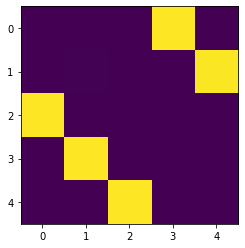

In [ ]:
from mmcls.datasets import build_dataloader, build_dataset
from mmcls.core.evaluation import calculate_confusion_matrix
dataset = build_dataset(cfg.data.test)
pred = mmcv.load("./result.pkl")['class_scores']
matrix = calculate_confusion_matrix(pred, dataset.get_gt_labels())
print(matrix)
import matplotlib.pyplot as plt
plt.imshow(matrix)

In [ ]:
kwargs = {}
eval_kwargs = cfg.get('evaluation', {}).copy()
for key in [
    'interval', 'tmpdir', 'start', 'gpu_collect', 'save_best',
    'rule', 'dynamic_intervals'
]:
    eval_kwargs.pop(key, None)
eval_kwargs.update(dict(metric='accuracy', **kwargs))
metric = dataset.evaluate(outputs, **eval_kwargs)
print(metric)

{'accuracy_top-1': 20.0}


In [ ]:
eval_kwargs

{'metric': 'accuracy', 'metric_options': {'topk': (1,)}}

In [ ]:
# cfg = Config.fromfile('./configs/detr/detr_r50_8x2_150e_coco.py')
cfg = Config.fromfile('configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py')
# replace the ${key} with the value of cfg.key
# cfg = replace_cfg_vals(cfg)
# model = model.cfg
# update data root according to MMDET_DATASETS


NameError: ignored

In [ ]:
# build the dataloader
distributed = False

test_dataloader_default_args = dict(
    samples_per_gpu=1, workers_per_gpu=1, dist=distributed, shuffle=False)

test_loader_cfg = {
    **test_dataloader_default_args,
    **cfg.data.get('test_dataloader', {})
 }
model = build_classifier(cfg.model)
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset, **test_loader_cfg)

In [ ]:
outputs = mmcls.apis.single_gpu_test(model, data_loader, show=False, out_dir=None)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 13.7 task/s, elapsed: 73s, ETA:     0s

In [ ]:
for key in ['interval', 'tmpdir', 'start', 'gpu_collect', 'save_best','rule', 'dynamic_intervals']:
  eval_kwargs.pop(key, None)

In [ ]:
dataset = [build_dataset(cfg.data.val)]

In [ ]:
eval_kwargs.update(dict(metric='accuracy', **kwargs))
metric = dataset.evaluate(outputs, **eval_kwargs)

AttributeError: ignored